# Load libraries

In [6]:
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer as Imputer
from sklearn.ensemble import RandomForestClassifier

# Read train and test data

In [7]:
train_X_base = pd.read_csv('../lab2/train_X.csv').set_index('id')
train_X_normalized = pd.read_csv('../lab2/train_X_normalized.csv').set_index('id')
train_X_frequent = pd.read_csv('../lab2/train_X_frequent.csv').set_index('id')
train_X_normalized_frequent = pd.read_csv('../lab2/train_X_normalized_frequent.csv').set_index('id')
test_X = pd.read_csv('../lab2/test_X.csv').set_index('id')
train_y_base = pd.read_csv('../lab2/train_y.csv').set_index('id')['label']
train_y_minus = pd.read_csv('../lab2/train_y_minus.csv').set_index('id')['label']

## Select data

In [8]:
X = train_X_normalized
y = train_y_base

## Split to validate

In [472]:
from sklearn.model_selection import train_test_split

train_X, validate_X, train_y, validate_y= train_test_split(X, y, test_size=0.2, random_state=42)

## Choose feature

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

params = {
    'alpha': [1e-1, 1e-2, 1e-3, 1e-4],
    'penalty': ['l1'],
    'tol': [1e-4],
    'max_iter': [10000],
    'loss': ['log'],
}

sgd = SGDClassifier()

clf_choose = GridSearchCV(sgd, params, cv=5, n_jobs=-1, scoring='neg_log_loss', verbose=10)
clf_choose.fit(train_X, train_y)
;

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1655s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed:    0.4s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed:    1.3s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed:    1.5s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:    1.7s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  15 out of  20 | elapsed:    1.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  20 | elapsed:    4.5s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    6.5s finished


''

In [29]:
clf_choose.best_params_, clf_choose.best_score_

({'alpha': 0.001,
  'loss': 'log',
  'max_iter': 10000,
  'penalty': 'l1',
  'tol': 0.0001},
 -0.2759315641299483)

In [30]:
eps = 1e-3
best_features = clf_choose.best_estimator_.coef_[0]
best_columns = train_X.columns[np.abs(best_features) > eps]
X_columns = X[best_columns]
train_X_columns = train_X[best_columns]
test_x_columns = test_X[best_columns]
validate_X_columns = validate_X[best_columns]

## Find best params

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

params = {
    'alpha': [1e-1, 1e-2, 1e-3],
    'penalty': ['l2'],
    'tol': [1e-4],
    'max_iter': [10000],
}

sgd = SGDClassifier(loss='log')

clf_params = GridSearchCV(sgd, params, cv=5, n_jobs=-1, scoring='neg_log_loss')
clf_params.fit(train_X_columns, train_y)
;

''

In [32]:
clf_params.best_params_

{'alpha': 0.1,
 'class_weight': None,
 'max_iter': 10000,
 'penalty': 'l2',
 'tol': 0.0001}

In [33]:
df = pd.DataFrame([])

In [34]:
df['params'] = clf_params.cv_results_['params']
df['mts'] = clf_params.cv_results_['mean_test_score']
df = df.set_index('params')
# df[df['mts'] > -0.235]
df

mts
params                                                      
{'alpha': 0.1, 'class_weight': 'balanced', 'max... -0.514223
{'alpha': 0.1, 'class_weight': None, 'max_iter'... -0.239297
{'alpha': 0.01, 'class_weight': 'balanced', 'ma... -0.525052
{'alpha': 0.01, 'class_weight': None, 'max_iter... -0.240684
{'alpha': 0.001, 'class_weight': 'balanced', 'm... -0.597352
{'alpha': 0.001, 'class_weight': None, 'max_ite... -0.248868
{'alpha': 0.0001, 'class_weight': 'balanced', '... -2.526207
{'alpha': 0.0001, 'class_weight': None, 'max_it... -0.388833

## Validate best params

In [26]:
clf = clf_params.best_estimator_

In [27]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(clf, train_X_columns, train_y, cv=5, n_jobs=-1, scoring='neg_log_loss')
-np.mean(score)

0.2449018134160673

In [485]:
[
    ({'alpha': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.0001},
    0.2341898957887921,
    0.28052853723986815)
]

[({'alpha': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'tol': 0.0001},
  0.2341898957887921)]

## Validate params

In [490]:
param = {'eta0': 0.001,
  'learning_rate': 'invscaling',
  'max_iter': 10000,
  'penalty': 'l2',
  'power_t': 0.30000000000000004,
  'tol': 1e-05,
'loss': 'log',
}
clf = SGDClassifier(**param)
score = cross_val_score(clf, X, y, cv=5, n_jobs=-1, scoring='neg_log_loss')
-np.mean(score)

0.24177094967561805

## Make predictions

In [276]:
clf_params.best_params_

{'alpha': 0.01, 'max_iter': 5000, 'penalty': 'l2', 'tol': 0.0001}

In [277]:
clfSGD.best_params_

{'alpha': 0.001, 'max_iter': 10000, 'penalty': 'l1', 'tol': 1e-05}

In [278]:
clf_predict = clf_params.best_estimator_
clf_predict.fit(X, y)
predict = clf_predict.predict_proba(test_X)
predict = predict[:, 1]
predict

array([1.        , 1.        , 0.99985581, ..., 0.63379303, 0.99999991,
       0.96486185])

In [279]:
len(predict)

1366

# Save predictions

In [280]:
dfpred = pd.DataFrame()
dfpred['Id'] = np.arange(len(ypred))
dfpred['Prediction'] = ypred

dfpred.to_csv('y_predicted_2.csv', index = False)

## Experiments

In [399]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

params = {
#     'alpha': [1e-2], # 1e-1,  , 1e-3, 1e-4
#     'learning_rate': ['optimal'],
#     'penalty': ['l1', 'l2', 'elasticnet'],
    'penalty': ['l2'],
    'tol': [1e-5], # 1e-6, 1e-4, 
    'max_iter': [10000], # 5000, 
#     'learning_rate': ['adaptive'],
#     'eta0': [1.6e-5],
#     'learning_rate': ['invscaling'],
#     'eta0': [1e-3],
#     'power_t': [0.3]
}

sgd = SGDClassifier(loss='log', n_jobs=-1)
columns = train_X_columns.columns
columns = X.columns

coef_init = (np.random.random_sample((len(columns),)) - 1) / len(columns)
# coef_init = [0] * len(columns)
# coef_init = None

clf_exp = GridSearchCV(sgd, params, cv=5, n_jobs=-1, scoring='neg_log_loss')
clf_exp.fit(X[columns], train_y_base, coef_init=coef_init)
;

''

In [400]:
clf_exp.best_params_, clf_exp.best_score_

({'eta0': 0.001,
  'learning_rate': 'invscaling',
  'max_iter': 10000,
  'penalty': 'l2',
  'power_t': 0.30000000000000004,
  'tol': 1e-05},
 -0.24177237233040033)

In [396]:
clf_exp.best_params_, clf_exp.best_score_

({'alpha': 0.01,
  'eta0': 0.001,
  'learning_rate': 'invscaling',
  'max_iter': 10000,
  'penalty': 'l2',
  'power_t': 0.30000000000000004,
  'tol': 1e-05},
 -0.24051801334928163)

In [374]:
clf_exp.best_params_, clf_exp.best_score_

({'alpha': 0.01, 'max_iter': 10000, 'penalty': 'l2', 'tol': 1e-05},
 -0.24875362940229762)

In [17]:
df2 = pd.DataFrame([])

In [18]:
sample = 'mts'
df2['params'] = clf_choose.cv_results_['params']
df2[sample] = clf_choose.cv_results_['mean_test_score']
df2 = df2.set_index('params')
df2

mts
params                                                      
{'alpha': 0.1, 'class_weight': 'balanced', 'los... -0.898405
{'alpha': 0.1, 'class_weight': None, 'loss': 'l... -0.296507
{'alpha': 0.01, 'class_weight': 'balanced', 'lo... -0.524215
{'alpha': 0.01, 'class_weight': None, 'loss': '... -0.476201
{'alpha': 0.001, 'class_weight': 'balanced', 'l... -0.654821
{'alpha': 0.001, 'class_weight': None, 'loss': ... -0.283475
{'alpha': 0.0001, 'class_weight': 'balanced', '... -4.879360
{'alpha': 0.0001, 'class_weight': None, 'loss':... -0.537176

## Experiments 2

In [496]:
tests = [{
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'solver': ['sgd'],
    'learning_rate': ['constant'],
    'learning_rate_init': [1e-4, 1e-3, 1e-2, 1e-1],
    
#     'momentum': np.arange(0.8, 1, 0.05),
    'nesterovs_momentum': [True, False],
    
    'tol': [1e-5],
    'max_iter': [10000],
}, {
    'learning_rate_init': [0.001],
    'learning_rate': ['invscaling'],
    'max_iter': [10000],
    'penalty': ['l2'],
    'power_t': [0.3],
    'tol': [1e-05],
    
    'solver': ['sgd'],
    
#     'momentum': np.arange(0.5, 1, 0.1),
    'nesterovs_momentum': [True, False],
    
}, {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'solver': ['sgd'],
    
    'learning_rate': ['adaptive'],
    'learning_rate_init': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    
#     'momentum': np.arange(0.8, 1, 0.05),
    'nesterovs_momentum': [True, False],
    
    'tol': [1e-5],
    'max_iter': [10000],   
}, {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'solver': ['lbfgs'],
    'max_fun': [20000],
    'tol': [1e-5],
    'max_iter': [10000],  
}, {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1],
    'solver': ['adam'],
    'learning_rate_init': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    
    'tol': [1e-5],
    'max_iter': [10000],  
}
    
]

In [437]:
res = []

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier



# params = {
#     'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
#     'solver': ['sgd'],
#     'learning_rate': ['constant'],
#     'learning_rate_init': [1e-5, 1e-3, 1e-2, 1e-1],
    
#     'learning_rate': ['invscaling'],
#     'learning_rate_init': [1e-5, 1e-3, 1e-2, 1e-1],
#     'power_t': np.arange(0, 1, 0.1)
    
#     'learning_rate': ['adaptive'],
#     'learning_rate_init': [1e-6, 1e-5, 1e-3, 1e-2, 1e-1],
    
#     'momentum': np.arrage(0.8, 1, 0.05),
#     'nesterovs_momentum': [True, False]
    
#     'solver': ['lbfgs'],
# #     'solver': ['adam'],
    
# #     'learning_rate': ['optimal'],
# #     'penalty': ['l1', 'l2', 'elasticnet'],
# #     'penalty': ['l2'],
#     'tol': [1e-5], # 1e-6, 1e-4, 
#     'max_iter': [10000], # 5000, 
# #     'learning_rate': ['adaptive'],
# #     'eta0': [1.6e-5],
# #     'learning_rate': ['invscaling'],
# #     'eta0': [1e-3],
# #     'power_t': [0.3]
# }
params = tests[1]

sgd = MLPClassifier()
columns = train_X_columns.columns
columns = X.columns

# coef_init = (np.random.random_sample((len(columns),)) - 1) / len(columns)
# coef_init = [0] * len(columns)
# coef_init = None

clf_exp = GridSearchCV(sgd, params, cv=5, n_jobs=-1, scoring='neg_log_loss', verbose=11)
clf_exp.fit(X[columns], y)
res += [[clf_exp.best_score_, clf_exp.best_params_]]
;

In [ ]:
res

In [447]:
clf_exp.best_params_, clf_exp.best_score_

({'alpha': 0.1,
  'learning_rate_init': 0.1,
  'max_iter': 10000,
  'solver': 'adam',
  'tol': 1e-05},
 -0.27023561802311424)

In [ ]:
df2 = pd.DataFrame([])

In [ ]:
sample = 'mts'
df2['params'] = clf_exp.cv_results_['params']
df2[sample] = clf_exp.cv_results_['mean_test_score']
df2 = df2.set_index('params')
df2[df2[sample] > -0.24]
df2

### Static class

In [62]:
from sklearn.base import BaseEstimator, ClassifierMixin

eps = 0.0001
steps = 10000

class MyClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        const = 0.1
    ):
        self.const = const

    def fit(self, X, y):
        return self

    def predict(self, _X):
        X = _X.copy()
        X['prediction'] = 1
        
        return X[['prediction']]

    def predict_proba(self, _X):
        X = _X.copy()
        
        return np.array([[1 - self.const, self.const]] * len(X))

In [73]:
clf = MyClassifier()
res = GridSearchCV(clf, {'const': np.arange(0.05, 0.15, 0.01)}, cv=5, n_jobs=-1, scoring='neg_log_loss')
res.fit(train_X, train_y)

GridSearchCV(cv=5, error_score=nan, estimator=MyClassifier(const=0.5),
             iid='deprecated', n_jobs=-1,
             param_grid={'const': array([0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11, 0.12, 0.13, 0.14])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_log_loss', verbose=0)

In [74]:
res.cv_results_

{'mean_fit_time': array([0.09246573, 0.10665016, 0.11878223, 0.11293263, 0.1055232 ,
        0.09351177, 0.10357652, 0.0922689 , 0.11170554, 0.0825253 ]),
 'std_fit_time': array([0.00277106, 0.00633377, 0.01407192, 0.00802276, 0.00270737,
        0.01299376, 0.02989887, 0.02793889, 0.02619691, 0.02536941]),
 'mean_score_time': array([0.00613976, 0.00503287, 0.00527897, 0.00568495, 0.0058506 ,
        0.0061419 , 0.00570002, 0.0053587 , 0.00556397, 0.00423045]),
 'std_score_time': array([0.00068283, 0.00025357, 0.00027577, 0.00032422, 0.00147868,
        0.00053973, 0.00077307, 0.00116094, 0.00150412, 0.00143175]),
 'param_const': masked_array(data=[0.05, 0.060000000000000005, 0.07, 0.08000000000000002,
                    0.09000000000000001, 0.1, 0.11000000000000001,
                    0.12000000000000001, 0.13, 0.14],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'pa

## Experiment result

In [339]:
initial_coef = df2

In [340]:
initial_coef

mts_0-initial  \
params                                                              
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...      -0.240112   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...      -0.249586   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...      -0.242912   

                                                    mts_initial  mts_rand  \
params                                                                      
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...    -0.243515 -0.248842   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...    -0.254371 -0.250889   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...    -0.243335 -0.244337   

                                                    mts_rand/10  mts_rand/+-  \
params                                                                         
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...    -0.238938    -0.282667   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...    -0.258443    -0.250739   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...    -0.242433    -0.241435   

                                                    mts_rand/n  \
params                                                           
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...   -0.237637   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...   -0.248207   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...   -0.241699   

                                                    mts_rand/n/minus  \
params                                                                 
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...         -0.247131   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...         -0.248317   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...         -0.244323   

                                                    mts_rand/n/selected  \
params                                                                    
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...            -0.233289   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...            -0.232039   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...            -0.231930   

                                                    mts_rand-initial-selected  \
params                                                                          
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...                  -0.234028   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...                  -0.231752   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...                  -0.231972   

                                                    mts_rand-0-selected  
params                                                                   
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...            -0.234126  
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...            -0.231829  
{'alpha': 0.01, 'max_iter': 10000, 'penalty': '...            -0.231943

Automatically created module for IPython interactive environment

learning on dataset moons
training: constant learning-rate
Training set score: 0.934431
Training set loss: 0.191176
Log score: -0.302925
training: constant with momentum
Training set score: 0.948460
Training set loss: 0.142455
Log score: -0.368093
training: constant with Nesterov's momentum
Training set score: 0.949375
Training set loss: 0.108180
Log score: -0.408392
training: inv-scaling learning-rate
Training set score: 0.914608
Training set loss: 0.252754
Log score: -0.259956
training: inv-scaling with momentum
Training set score: 0.919488
Training set loss: 0.229774
Log score: -0.244118
training: inv-scaling with Nesterov's momentum
Training set score: 0.916438
Training set loss: 0.233649
Log score: -0.246744
training: adam
Training set score: 0.961879
Training set loss: 0.101542
Log score: -0.381123


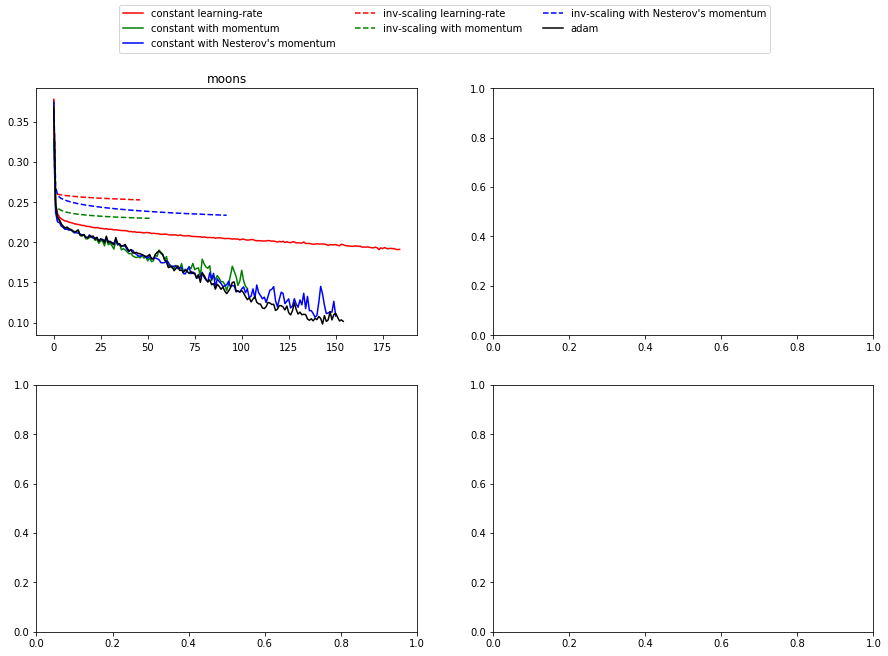

In [458]:
print(__doc__)

import warnings

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
# from sklearn.preprocessing import MinMaxScaler
# from sklearn import datasets
from sklearn.exceptions import ConvergenceWarning

# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]


def plot_on_dataset(X, y, ax, name):
    # for each dataset, plot learning for each learning strategy
    print("\nlearning on dataset %s" % name)
    ax.set_title(name)

#     X = MinMaxScaler().fit_transform(X)
    mlps = []
    if name == "digits":
        # digits is larger but converges fairly quickly
        max_iter = 15
    else:
        max_iter = 400

    for label, param in zip(labels, params):
        print("training: %s" % label)
        mlp = MLPClassifier(random_state=0,
                            max_iter=max_iter, **param)

        # some parameter combinations will not converge as can be seen on the
        # plots so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning,
                                    module="sklearn")
            mlp.fit(X, y)

        mlps.append(mlp)
        print("Training set score: %f" % mlp.score(X, y))
        print("Training set loss: %f" % mlp.loss_)
        score = cross_val_score(mlp, X, y, cv=5, n_jobs=-1, scoring='neg_log_loss')
        print("Log score: %f" % np.mean(score))
        
    for mlp, label, args in zip(mlps, labels, plot_args):
        ax.plot(mlp.loss_curve_, label=label, **args)


fig, axes = plt.subplots(2, 2, figsize=(15, 10))
# load / generate some toy datasets
# iris = datasets.load_iris()
# X_digits, y_digits = datasets.load_digits(return_X_y=True)
# data_sets = [(iris.data, iris.target),
#              (X_digits, y_digits),
#              datasets.make_circles(noise=0.2, factor=0.5, random_state=1),
#              datasets.make_moons(noise=0.3, random_state=0)]
data_sets = [(train_X_columns, train_y)]

for ax, data, name in zip(axes.ravel(), data_sets, ['moons']):
    plot_on_dataset(*data, ax=ax, name=name)

fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()